In [1]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta

import matplotlib.pyplot as plot
import networkx as nx
import seaborn as sns

from pyomo.environ import *
from pyomo.opt import SolverFactory
from gurobipy import GRB

In [2]:
#id directories
data_dir = os.getcwd().replace('/model', '/data')
results_dir = os.getcwd().replace('/model', '/results')


reliability_levels = [0,1,2]
budget_levels = range(1,30+1)

level_amount_incrememented = 10000
warehouse_cap_level = 3 #time intervals of supply that can be stored

trade_off_dict = {}

In [3]:
#define sets
K = 1
I = 4
T = 10

In [4]:
def initialize_model(CAP_reliability, DEMAND_reliability, 
                     budget_level):
    
    global warehouse_cap_level
    global level_amount_incrememented
    global K
    global I
    global T
    
    #define parameters

    #rank
    r_k_dict = {
        1 : 1
    }

    #quality (supplier 4 has the highest quality)
    q_k_i_dict = {
        tuple([1,1]) : 2,
        tuple([1,2]): 2,
        tuple([1,3]): 2,
        tuple([1,4]): 3
    }

    #starting inventory
    z_k_i_init_dict = {
        tuple([1,1]) : 12000/4,
        tuple([1,2]) : 12000/4,
        tuple([1,3]) : 12000/4,
        tuple([1,4]) : 12000/4
    }

    alpha_k_init_dict = {
        1 : 1000
    }

    #lead time (supplier 3 has the lowest lead time)
    f_k_i_tDiff_dict = {}

    for k in range(1,K+1):
        for i in range(1,I+1):
            for t in range(T+1):
                if (i == 3):
                    if (t == 0):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                    elif (t == 1):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                    elif (t == 2):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                    elif (t == 3):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                    else:
                        f_k_i_tDiff_dict[tuple([k,i,t])] = 0
                else:
                    if (t == 3):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                    elif (t == 4):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                    elif (t == 5):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                    elif (t == 6):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                    else:
                        f_k_i_tDiff_dict[tuple([k,i,t])] = 0


    o_k_i_t_dict = {}

    for k in range(1,K+1):
        for i in range(1,I+1):
            for t in range(1,T+1):
                if t < 3:
                    o_k_i_t_dict[tuple([k,i,t])] = 1000
                else:
                    o_k_i_t_dict[tuple([k,i,t])] = 0

    #size
    s_k_dict = {
        1 : .5
    }

    #warehouse capacity
    h = 11918*.5*warehouse_cap_level #assuming warehouse capacity is not an issue

    #cost (supplier 2 has the lowest cost)
    c_k_i_dict = {
        tuple([1,1]) : 1,
        tuple([1,2]) : .8,
        tuple([1,3]) : 1,
        tuple([1,4]) : 1
    }

    b = 12000*budget_level

    #lead time (supplier 1 has the higest capacity)
    CAP_k_i_t_dict_mu_sd = {}

    for k in range(1,K+1):
        for i in range(1,I+1):
            for t in range(T+1):
                if (i == 1):
                    CAP_k_i_t_dict_mu_sd[tuple([k,i,t])] = [30000, 30000*.1]
                else:
                    CAP_k_i_t_dict_mu_sd[tuple([k,i,t])] = [10000, 10000*.1]

    D_k_t_dict_mu_sd = {
        tuple([1,1]) : [12000, 1200],
        tuple([1,2]) : [12000, 1200],
        tuple([1,3]) : [12000, 1200],
        tuple([1,4]) : [12000, 1200],
        tuple([1,5]) : [12000, 1200],
        tuple([1,6]) : [12000, 1200],
        tuple([1,7]) : [12000, 1200],
        tuple([1,8]) : [12000, 1200],
        tuple([1,9]) : [12000, 1200],
        tuple([1,10]) : [12000, 1200]
    }
    
    model = ConcreteModel()

    #####define sets#######
    model.K = Set(initialize = range(1,K+1))
    model.I = Set(initialize = range(1,I+1))
    model.T = Set(initialize = range(1,T+1))

    ####initialize parameters####

    def rank_param_initialize(model, k):
        return(r_k_dict.get(k))

    model.r_k = Param(model.K, initialize = rank_param_initialize)

    #model.r_k.pprint()

    def penalty_param_initialize(model, k):
        return(1/model.r_k[k])

    model.p_k = Param(model.K, initialize = penalty_param_initialize)

    #model.p_k.pprint()

    def discount_param_initialize(model, k, t):
        discount_temp = model.p_k[k]
        #time_diff = T-t
        return(1/((1+discount_temp)**(t-1)))

    model.tau_k_t = Param(model.K, model.T, initialize = discount_param_initialize)

    #model.tau_k_t.pprint()

    def quality_param_initialize(model, k, i):
        return(q_k_i_dict.get(tuple([k,i])))

    model.q_k_i = Param(model.K, model.I, initialize = quality_param_initialize)

    #model.q_k_i.pprint()

    def beg_inv_param_initialize(model, k, i):
        return(z_k_i_init_dict.get(tuple([k,i])))

    model.z_k_i_init = Param(model.K, model.I, initialize = beg_inv_param_initialize)

    #model.z_k_i_init.pprint()

    def unfulfilled_demand_param_initialize(model, k):
        return(alpha_k_init_dict.get(k))

    model.alpha_k_intialize = Param(model.K, initialize = unfulfilled_demand_param_initialize)

    #model.alpha_k_intialize.pprint()

    def delay_dist_param_initialize(model, k, i, t):
        return(f_k_i_tDiff_dict.get(tuple([k,i,t])))

    model.f_k_i_tDiff = Param(model.K, model.I, model.T, initialize = delay_dist_param_initialize)

    #model.f_k_i_tDiff.pprint()

    def incoming_orders_initialize(model, k, i, t):
        return(o_k_i_t_dict.get(tuple([k,i,t])))

    model.o_k_i_t = Param(model.K, model.I, model.T, initialize = incoming_orders_initialize)

    #model.o_k_i_t.pprint()

    def item_size_param_initialize(model, k):
        return(s_k_dict.get(k))

    model.s_k = Param(model.K, initialize = item_size_param_initialize)

    #model.s_k.pprint()

    def warehouse_cap_param_initialize(model):
        return(h)

    model.h = Param(initialize = h)

    #model.h.pprint()

    def cost_param_initialize(model, k, i):
        return(c_k_i_dict.get(tuple([k,i])))

    model.c_k_i = Param(model.K, model.I, initialize = cost_param_initialize)

    #model.c_k_i.pprint()

    def budget_param_initialize(model):
        return(b)

    model.b = Param(initialize = budget_param_initialize)

    #model.b.pprint()

    def supplier_cap_param_initialize(model, k, i, t):
        temp = CAP_k_i_t_dict_mu_sd.get(tuple([k,i,t]))
        mean = temp[0]
        sd = CAP_reliability*temp[1]
        return(mean+sd)

    model.cap_k_i_t = Param(model.K, model.I, model.T, initialize = supplier_cap_param_initialize)

    #model.cap_k_i_t.pprint()

    #assume preparing for one sd above the mean
    def mu_plus_sigma_demand_param_initialize(model, k, t):
        temp = D_k_t_dict_mu_sd.get(tuple([k,t]))
        mean = temp[0]
        sd = DEMAND_reliability*temp[1]
        return(mean+sd)

    model.d_k_t = Param(model.K, model.T, initialize = mu_plus_sigma_demand_param_initialize)

    #model.d_k_t.pprint()

    ####initialize variables####
    model.x_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount ordered
    model.y_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount recieved
    model.z_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)
    model.alpha_k_t = Var(model.K, model.T, within = NonNegativeReals)
    model.beta_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)
    
    return(model)

In [5]:
def initialize_objective(model):
    model.Objective = Objective(expr = 
                                (sum(model.q_k_i[k,i]*sum(model.tau_k_t[k,t]*model.beta_k_i_t[k,i,t] 
                                                          for t in model.T) 
                                     for i in model.I for k in model.K)),
                                sense = maximize)
    return(model)

In [6]:
def initialize_constraints(model):
    def beggining_inventory_constraint_initialize(model, k, i):
        return(model.z_k_i_t[k,i,1] == model.z_k_i_init[k,i])

    model.beggining_inventory_constraint = Constraint(model.K, model.I, rule = beggining_inventory_constraint_initialize)
    
    def initalize_unsatisfied_demand_constraint_initialize(model, k):
        return(model.alpha_k_t[k,1] == model.alpha_k_intialize[k])

    model.initalize_unsatisfied_demand_constraint_initialize = \
    Constraint(model.K, rule = initalize_unsatisfied_demand_constraint_initialize)
    
    def incoming_orders_constraint_initialize(model, k, i, t):
        return(model.y_k_i_t[k,i,t] - 
               sum(model.f_k_i_tDiff[k, i, t-t_ordered_time]*model.x_k_i_t[k,i,t_ordered_time] 
                   for t_ordered_time in range(1,t)) - model.o_k_i_t[k,i,t] == 0)

    model.incoming_ordered_constraint = Constraint(model.K, model.I, model.T, 
                                                   rule = incoming_orders_constraint_initialize)
    
    def calculate_available_inventory_constraint_initialize(model, k, i, t):
        if (t > 1):
            return(model.z_k_i_t[k,i,t] - model.z_k_i_t[k,i,t-1] - model.y_k_i_t[k,i,t-1] + model.beta_k_i_t[k,i,t-1] == 0)
        else:
            return(Constraint.Skip)

    model.calculate_available_inventory_constraint = Constraint(model.K, model.I, model.T,
                                                                rule = 
                                                                calculate_available_inventory_constraint_initialize)
    
    def cannot_fulfill_more_than_available_constraint_initialize(model, k,i,t):
        return(model.beta_k_i_t[k,i,t] - model.z_k_i_t[k,i,t] <= 0)

    model.cannot_fulfill_more_than_available_constraint = \
    Constraint(model.K, model.I, model.T, rule = cannot_fulfill_more_than_available_constraint_initialize)
    
    def calculate_unsatisfied_demand_constraint_initialize(model,k,t):
        if t > 1:
            return(model.alpha_k_t[k,t] - model.alpha_k_t[k,t-1] + sum(model.beta_k_i_t[k,i,t] for i in model.I) == \
                   model.d_k_t[k,t])
        else:
            return(Constraint.Skip)

    model.calculate_unsatisfied_demand_constraint = \
    Constraint(model.K, model.T, rule = calculate_unsatisfied_demand_constraint_initialize)
    
    def warehouse_capacity_constraint_initialize(model, t):
        return(sum(model.s_k[k]*model.z_k_i_t[k,i,t] for k in model.K for i in model.I) <= model.h)

    model.warehouse_capacity_constraint = \
    Constraint(model.T, rule = warehouse_capacity_constraint_initialize)
    
    def budget_constraint_initialize(model):
        return(sum(model.c_k_i[k,i]*model.x_k_i_t[k,i,t] 
                   for k in model.K for i in model.I for t in model.T) 
               <= model.b)

    model.budget_constraint = \
    Constraint(rule = budget_constraint_initialize)
    
    def supplier_constraint_initialize(model, k, i, t):
        return(model.x_k_i_t[k,i,t] <= model.cap_k_i_t[k,i,t])

    model.supplier_constraint = \
    Constraint(model.K, model.I, model.T, rule = supplier_constraint_initialize)
    
    return(model)

In [7]:
def extract_data(model, reliability_level, budget):
    
    #extract from unsatisfied_df
    def unsatisfied_df_update(unsatisfied_df):
        if unsatisfied_df.empty:
            unsatisfied_df = pd.DataFrame(list(model.alpha_k_t.extract_values().items()),\
                                          columns = ['sets','units_unsatisfied'])
            unsatisfied_df.loc[:,'item_type']=unsatisfied_df.sets.map(lambda x:x[0])
            unsatisfied_df.loc[:,'time_interval']=unsatisfied_df.sets.map(lambda x:x[1])
            unsatisfied_df = unsatisfied_df[['item_type', 'time_interval', 'units_unsatisfied']]
            unsatisfied_df ['reliability_level'] = [reliability_level]*len(unsatisfied_df)
            unsatisfied_df['budget'] = [budget]*len(unsatisfied_df)
            return(unsatisfied_df)
        else:
            unsatisfied_df_temp = pd.DataFrame(list(model.alpha_k_t.extract_values().items()),\
                                          columns = ['sets','units_unsatisfied'])
            unsatisfied_df_temp.loc[:,'item_type']=unsatisfied_df_temp.sets.map(lambda x:x[0])
            unsatisfied_df_temp.loc[:,'time_interval']=unsatisfied_df_temp.sets.map(lambda x:x[1])
            unsatisfied_df_temp = unsatisfied_df_temp[['item_type', 'time_interval', 'units_unsatisfied']]
            unsatisfied_df_temp ['reliability_level'] = [reliability_level]*len(unsatisfied_df_temp)
            unsatisfied_df_temp['budget'] = [budget]*len(unsatisfied_df_temp)

            return(unsatisfied_df.append(unsatisfied_df_temp, ignore_index=True))
        
    #extract from satisfied_df
    def fulfilled_df_update(fulfilled_df):
        if fulfilled_df.empty:
            fulfilled_df = pd.DataFrame(list(model.beta_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
            fulfilled_df.loc[:,'item_type']=fulfilled_df.sets.map(lambda x:x[0])
            fulfilled_df.loc[:,'supplier']=fulfilled_df.sets.map(lambda x:x[1])
            fulfilled_df.loc[:,'time_interval']=fulfilled_df.sets.map(lambda x:x[2])
            fulfilled_df['reliability_level'] = [reliability_level]*len(fulfilled_df)
            fulfilled_df['budget'] = [budget]*len(fulfilled_df)
            return(fulfilled_df)
        else:
            fulfilled_df_temp = pd.DataFrame(list(model.beta_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
            fulfilled_df_temp.loc[:,'item_type']=fulfilled_df_temp.sets.map(lambda x:x[0])
            fulfilled_df_temp.loc[:,'supplier']=fulfilled_df_temp.sets.map(lambda x:x[1])
            fulfilled_df_temp.loc[:,'time_interval']=fulfilled_df_temp.sets.map(lambda x:x[2])
            fulfilled_df_temp['reliability_level'] = [reliability_level]*len(fulfilled_df_temp)
            fulfilled_df_temp['budget'] = [budget]*len(fulfilled_df_temp)

            return(fulfilled_df.append(fulfilled_df_temp, ignore_index=True))
    
    global unsatisfied_df
    global fulfilled_df
    
    unsatisfied_df = unsatisfied_df_update(unsatisfied_df)
    fulfilled_df = fulfilled_df_update(fulfilled_df)
    
    return(unsatisfied_df, fulfilled_df)

In [8]:
fulfilled_df = pd.DataFrame()
unsatisfied_df = pd.DataFrame()

for r in reliability_levels:
    
    objective_itr = [0,1]
    b = 1
    while(objective_itr[b-1] < objective_itr[b]):    
        model = initialize_model(r, r, b)
        model = initialize_objective(model)
        model = initialize_constraints(model)
        opt = pyomo.opt.SolverFactory("glpk")
        results = opt.solve(model)
        opt.solve(model)
        
        #extract data
        trade_off_dict[tuple([r,b*10000])] = value(model.Objective) #model.Objective.value()
        objective_itr.append(value(model.Objective))#model.Objective.value())
        
        unsatisfied_df, fulfilled_df = extract_data(model, r, b*10000)
        
        b = b + 1

In [9]:
with open('test.csv', 'w') as f:
    for key in trade_off_dict.keys():
        f.write("%s,%s\n"%(key,trade_off_dict[key]))

In [11]:
trade_off_dict

{(0, 10000): 36225.0,
 (0, 20000): 37518.75,
 (0, 30000): 38601.5625,
 (0, 40000): 39421.875,
 (0, 50000): 40209.375,
 (0, 60000): 40959.375,
 (0, 70000): 41592.1875,
 (0, 80000): 41880.72916666667,
 (0, 90000): 41990.364583333336,
 (0, 100000): 42020.3125,
 (0, 110000): 42027.34375,
 (0, 120000): 42027.34375,
 (1, 10000): 36337.5,
 (1, 20000): 37659.375,
 (1, 30000): 38791.40625,
 (1, 40000): 39674.0625,
 (1, 50000): 40461.5625,
 (1, 60000): 41249.0625,
 (1, 70000): 41950.3125,
 (1, 80000): 42530.9375,
 (1, 90000): 42752.109375,
 (1, 100000): 42858.984375,
 (1, 110000): 42887.8125,
 (1, 120000): 42897.890625,
 (1, 130000): 42898.828125,
 (1, 140000): 42898.828125,
 (2, 10000): 36450.0,
 (2, 20000): 37800.0,
 (2, 30000): 38981.25,
 (2, 40000): 39926.25,
 (2, 50000): 40713.75,
 (2, 60000): 41501.25,
 (2, 70000): 42266.25,
 (2, 80000): 42924.375,
 (2, 90000): 43425.0,
 (2, 100000): 43621.92708333333,
 (2, 110000): 43724.479166666664,
 (2, 120000): 43755.3125,
 (2, 130000): 43767.65625,
 

In [14]:
budget = []
reliability = []
obj_value = []

for k in trade_off_dict.keys():
    obj_value.append(trade_off_dict.get(k))
    budget.append(k[1])
    if (k[0] == 2):
        reliability.append(r'$\theta^D > \theta^CAP$ = 0')
    elif (k[0] == 1):
        reliability.append(r'$\theta^D > \theta^CAP$ = 1')
    else:
        reliability.append(r'$\theta^D > \theta^CAP$ = 2')

In [13]:
trade_off_df = pd.DataFrame([budget,reliability, obj_value]).transpose()
trade_off_df.columns = ['budget', 'reliability', 'obj_value']

In [21]:
fulfilled_df_item_time = fulfilled_df.groupby(['item_type', 'time_interval', 
                      'reliability_level', 'budget'])['units_fulfilled'].sum().reset_index()

reliability_df = pd.merge(fulfilled_df_item_time[['item_type', 'time_interval', 'units_fulfilled',
                                                  'reliability_level', 'budget']], 
                          unsatisfied_df[['item_type', 'time_interval', 'units_unsatisfied',
                                          'reliability_level', 'budget']], 
                          how='left', on=['item_type','time_interval',
                                         'reliability_level', 'budget'])

reliability_df['total_number_of_open_requests'] = reliability_df['units_fulfilled'] +\
reliability_df['units_unsatisfied'] 

reliability_df['percent_unsatisfied'] = \
reliability_df['units_unsatisfied']/reliability_df['total_number_of_open_requests']

In [25]:
reliability_df_grouped = \
reliability_df.groupby(['reliability_level', 'budget'])['percent_unsatisfied'].sum().reset_index()

In [27]:
reliability_df_grouped['risk_of_understock'] = reliability_df_grouped['percent_unsatisfied']/(T*K)

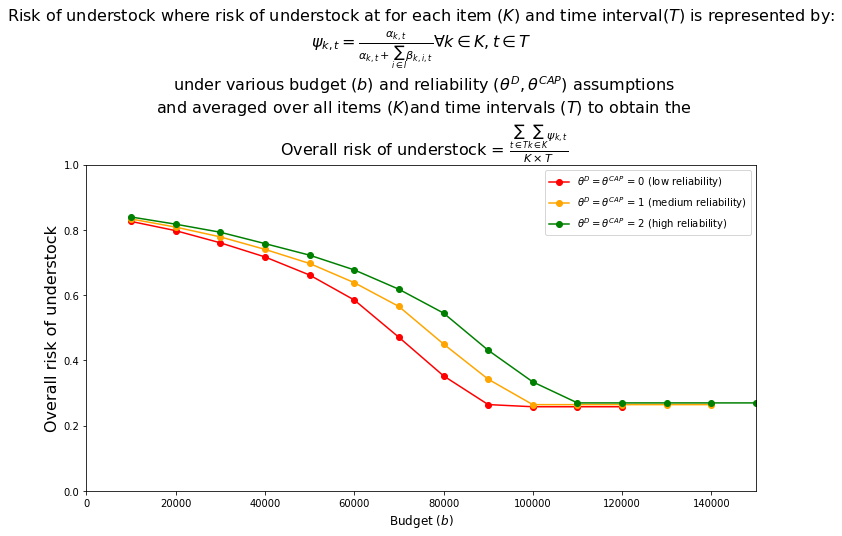

In [101]:
fig, ax = plot.subplots(figsize=(12,6))


ax.plot('budget', 'risk_of_understock', 
          data=reliability_df_grouped[reliability_df_grouped['reliability_level'] == 0],
         marker='o', color = 'red', label = r'$\theta^D = \theta^{CAP}$ = 0' + ' (low reliability)')
ax.plot('budget', 'risk_of_understock', 
          data=reliability_df_grouped[reliability_df_grouped['reliability_level'] == 1],
         marker='o', color = 'orange', label = r'$\theta^D = \theta^{CAP}$ = 1' + ' (medium reliability)')
ax.plot('budget', 'risk_of_understock', 
          data=reliability_df_grouped[reliability_df_grouped['reliability_level'] == 2],
         marker='o', color = 'green', label = r'$\theta^D = \theta^{CAP}$ = 2' + ' (high reliability)')

ax.set_xlabel('Budget (' + r'$b$' + ')', fontsize = 12)
ax.set_ylabel('Overall risk of understock', fontsize = 16)

ax.set(ylim=(0, 1), xlim=(0, max(reliability_df_grouped['budget'])))
ax.set_title('Risk of understock where risk of understock at for each item '+ r'$(K)$' + ' and time interval'+ r'$(T)$' + ' is represented by:\n'+\
             r'$\psi_{k,t} = \frac{\alpha_{k,t}}{\alpha_{k,t} + \sum_{i \in I} \beta_{k,i,t}} \forall k \in K, t \in T$' +
             '\n under various budget (' + r'$b$' + ') and reliability (' + r'$\theta^D, \theta^{CAP}$' + ') assumptions'\
             '\n and averaged over all items '+  r'$(K)$'+ 'and time intervals '+  r'$(T)$'+ ' to obtain the'\
             '\n Overall risk of understock = ' + r'$\frac{\sum_{t \in T} \sum_{k \in K} \psi_{k,t}}{K \times T}$',
             fontsize = 16)

plot.legend()

In [33]:
reliability_df[reliability_df['reliability_level'] == 0]

,item_type,time_interval,units_fulfilled,reliability_level,budget,units_unsatisfied,total_number_of_open_requests,percent_unsatisfied
0,1,1,12000.000000,0,10000,1000.000000,13000.0,0.076923
1,1,1,12000.000000,0,20000,1000.000000,13000.0,0.076923
2,1,1,12000.000000,0,30000,1000.000000,13000.0,0.076923
3,1,1,12000.000000,0,40000,1000.000000,13000.0,0.076923
4,1,1,12000.000000,0,50000,1000.000000,13000.0,0.076923
...,...,...,...,...,...,...,...,...
376,1,10,1066.666667,0,80000,11333.333333,12400.0,0.913978
377,1,10,11200.000000,0,90000,800.000000,12000.0,0.066667
378,1,10,12000.000000,0,100000,0.000000,12000.0,0.000000
379,1,10,12000.000000,0,110000,0.000000,12000.0,0.000000
